# **Dependencies Setup and Huggingface Token**

In [1]:
# Install required libraries
!pip install transformers datasets trl torch accelerate bitsandbytes onnx onnxruntime tensorboard wandb

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 485.4/485.4 kB 26.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 22.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 83.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 77.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 44.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 90.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [2]:
   import torch
   print(f"CUDA available: {torch.cuda.is_available()}")
   if torch.cuda.is_available():
       print(f"GPU name: {torch.cuda.get_device_name(0)}")
       print(f"GPU memory: {torch.cuda.get_device_properties(0).total_memory / 1e9} GB")

CUDA available: True
GPU name: NVIDIA L4
GPU memory: 23.795204096 GB


In [ ]:
import wandb
wandb.login()

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: latishabesariani (latishabesariani-city-university-of-hong-kong) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
from huggingface_hub import notebook_login

notebook_login()

# **Preparing Our Labeled Dataset**


1.   Load tokenizer and special tokens
2.   Load & filter dataset. Since we are doing sequence classification for end-of-utterance, it is best to have at least 3 context messages, where the last message is the current utterance
4. Check label distribution so we know if it's balanced or not
5. Make sure we format each of the turns in terms of assistant or user
6. Tokenize the data



In [9]:
from transformers import AutoConfig, AutoModelForSequenceClassification, AutoTokenizer
from datasets import Dataset
from trl import SFTConfig, SFTTrainer
from sklearn.metrics import accuracy_score
import random
import json

# --- 1. Setup: Load Tokenizer & Add Special Tokens ---
special_tokens = {
    "additional_special_tokens": ["<|user|>", "<|assistant|>"],
    "pad_token": "<|endoftext|>",
}
tokenizer = AutoTokenizer.from_pretrained("HuggingFaceTB/SmolLM2-135M-Instruct")
tokenizer.add_special_tokens(special_tokens)

# --- 2. Load & Use the Dataset Without Downsampling ---
import random
import json
from datasets import Dataset

with open("labeled_dataset.json", "r", encoding="utf-8") as f:
    try:
        data = json.load(f)
        print("JSON is valid!")
    except json.JSONDecodeError as e:
        print(f"JSON Error: {e}")

label_0 = [entry for entry in data if entry.get("label") == 0]
label_1 = [entry for entry in data if entry.get("label") == 1]
random.shuffle(label_0)
random.shuffle(label_1)

# Stratified Split (80/20) for Each Label
split_0 = int(len(label_0) * 0.8)
split_1 = int(len(label_1) * 0.8)

train_label_0 = label_0[:split_0]
test_label_0  = label_0[split_0:]
train_label_1 = label_1[:split_1]
test_label_1  = label_1[split_1:]

# Combine the label splits
train_data = train_label_0 + train_label_1
test_data  = test_label_0 + test_label_1

# Shuffle final train/test sets
random.shuffle(train_data)
random.shuffle(test_data)
ds = {
    "train": Dataset.from_list(train_data),
    "test":  Dataset.from_list(test_data)
}

print(f"Train dataset: Class 0: {len(train_label_0)}, Class 1: {len(train_label_1)}")
print(f"Test dataset:  Class 0: {len(test_label_0)},  Class 1: {len(test_label_1)}")

# --- 3. Format Each Example Correctly ---
def format_example(example):
    # Check if the 'context' has exactly three turns
    if len(example['context']) != 3:
        # Skipping a context with less or more than three turns
        return None

    # Build the conversation string from the 3 turns
    text = (
        f"<|user|> {example['context'][0]['content'].strip()} <|im_end|> "
        f"<|assistant|> {example['context'][1]['content'].strip()} <|im_end|> "
        f"<|user|> {example['context'][2]['content'].strip()} <|im_end|>"
    )

    # Tokenize the conversation
    inputs = tokenizer(text, padding="max_length", max_length=256, truncation=True)
    inputs["label"] = example["label"]
    return inputs

# Apply formatting function to both train and test datasets
ds["train"] = ds["train"].map(format_example, remove_columns=["context"])
ds["test"] = ds["test"].map(format_example, remove_columns=["context"])
# Note: Do not tokenize here so that SFTTrainer can handle it.

JSON is valid!
Train dataset: Class 0: 8712, Class 1: 8575
Test dataset:  Class 0: 2178,  Class 1: 2144


Map:   0%|          | 0/17287 [00:00<?, ? examples/s]

Map:   0%|          | 0/4322 [00:00<?, ? examples/s]

# **Configure Model, Training Arguments, and Train Our Model**

In [ ]:
import os
from transformers import AutoConfig, AutoModelForSequenceClassification, Trainer, TrainingArguments
import torch
import torch.nn as nn
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from trl import SFTConfig, SFTTrainer
from transformers import DataCollatorWithPadding
from peft import LoraConfig, get_peft_model, TaskType
from transformers import EarlyStoppingCallback

# --- 4. Load Model & Adjust for Classification ---
model_name = "HuggingFaceTB/SmolLM2-135M-Instruct"
config = AutoConfig.from_pretrained(model_name)
config.num_labels = 2
# config.hidden_dropout_prob = 0.1
# config.attention_probs_dropout_prob = 0.1
model = AutoModelForSequenceClassification.from_pretrained(model_name, config=config)
model.resize_token_embeddings(len(tokenizer))

# --- 4.1. Apply LoRA ---
lora_config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    r=128,
    lora_alpha=256,
    lora_dropout=0.0,
    bias="none",
    target_modules=["q_proj", "v_proj", "k_proj", "o_proj"],  # Use core projection layers
    modules_to_save=["classifier"]
)
model = get_peft_model(model, lora_config)

# Freeze base model parameters except for LoRA adapters and classifier
for name, param in model.named_parameters():
    if "lora_" not in name and "classifier" not in name:
        param.requires_grad = False

# --- 5. Define Training Arguments with SFTConfig ---
# Adjusted for ~16k train samples with batch size 16
training_args = SFTConfig(
    output_dir="outputs",
    per_device_train_batch_size=64,
    gradient_accumulation_steps=1,
    learning_rate=5e-4,           # High learning rate
    num_train_epochs=4,
    warmup_ratio=0.05,
    weight_decay=0.0,
    logging_steps=100,
    evaluation_strategy="steps",
    eval_steps=100,
    save_strategy="steps",
    save_steps=100,
    save_total_limit=3,
    report_to=["wandb"],
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    fp16=True,
    lr_scheduler_type="linear",
    optim="adamw_8bit",
    seed=3407,
)

def compute_metrics(p):
    predictions, labels = p
    predictions = predictions.argmax(axis=-1)
    accuracy = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {
        "accuracy": accuracy,
        "precision": precision,
        "recall": recall,
        "f1": f1
    }

# Finish any previous wandb runs
wandb.finish()

# Initialize a fresh wandb run
wandb.init(project="huggingface", reinit=True)

# Ensure a fresh run ID
import os
os.environ["WANDB_RUN_ID"] = wandb.util.generate_id()

# --- 6. Instantiate SFTTrainer with EarlyStoppingCallback ---
trainer = SFTTrainer(
    model,
    train_dataset=ds["train"],
    eval_dataset=ds["test"],
    args=training_args,
    compute_metrics=compute_metrics,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

Some weights of LlamaForSequenceClassification were not initialized from the model checkpoint at HuggingFaceTB/SmolLM2-135M-Instruct and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


eval/accuracy,▁▁▂▂▂▂▃▃█▃
eval/f1,▁▁▂▂▁▂▃▃█▃
eval/loss,███▇▇█▇▇▁▇
eval/mean_token_accuracy,▃▃▁▃█▇▅█▆█
eval/precision,▁▁▂▂▂▂▃▃█▃
eval/recall,▁▁▂▂▂▂▃▃█▃
eval/runtime,▁▁▁▁▁▁▁▁█▁
eval/samples_per_second,▃▁▃█▅▅▇▅▅▄
eval/steps_per_second,▃▁▃█▅▅▇▅▄▄
train/epoch,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█████
train/global_step,▁▁▂▂▃▃▄▄▅▅▆▆▇▇█████


Converting train dataset to ChatML:   0%|          | 0/17287 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/17287 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/17287 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/4321 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/4321 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/4321 [00:00<?, ? examples/s]

In [ ]:
# ------------------------------
# 9. Fine-Tune the Model
# ------------------------------
trainer.train()

Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
100,0.699800,0.653301,0.617450,0.617731,0.617450,0.617373
200,0.657600,0.657175,0.611895,0.623833,0.611895,0.600977
300,0.641800,0.655291,0.624624,0.629883,0.624624,0.619985
400,0.625000,0.635353,0.641287,0.641708,0.641287,0.640803
500,0.611000,0.640123,0.624855,0.634900,0.624855,0.616691
600,0.574700,0.638554,0.648230,0.651716,0.648230,0.645699
700,0.540700,0.622594,0.666744,0.669127,0.666744,0.665864
800,0.534200,0.623029,0.674150,0.674468,0.674150,0.673871
900,0.364600,0.719654,0.669984,0.672702,0.669984,0.668330
1000,0.332900,0.714541,0.682481,0.683084,0.682481,0.682064


/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetunin

TrainOutput(global_step=1084, training_loss=0.5385244957195436, metrics={'train_runtime': 1553.5822, 'train_samples_per_second': 44.509, 'train_steps_per_second': 0.698, 'total_flos': 1.284640456900608e+16, 'train_loss': 0.5385244957195436})

In [ ]:
# Evaluate on the training set
train_metrics = trainer.evaluate(eval_dataset=ds["train"])
print("Train Accuracy:", train_metrics.get("eval_accuracy", "Metric not found"))

# Evaluate on the test set
test_metrics = trainer.evaluate(eval_dataset=ds["test"])
print("Test Accuracy:", test_metrics.get("eval_accuracy", "Metric not found"))

In [ ]:
# ------------------------------
# 10. Save model and tokenizer
# ------------------------------
model.save_pretrained("outputs")
tokenizer.save_pretrained("outputs")

/usr/local/lib/python3.11/dist-packages/peft/utils/save_and_load.py:260: UserWarning: Setting `save_embedding_layers` to `True` as the embedding layer has been resized during finetuning.
  warnings.warn(


('outputs/tokenizer_config.json',
 'outputs/special_tokens_map.json',
 'outputs/vocab.json',
 'outputs/merges.txt',
 'outputs/added_tokens.json',
 'outputs/tokenizer.json')

# **Pre-processing Our Fine-tuned Model**

In [ ]:
class ModelWrapper(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.config = model.config

    def forward(self, input_ids, attention_mask):
        outputs = self.model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            return_dict=True
        )
        # Get probabilities for both classes and return them
        logits = outputs.logits
        probabilities = torch.softmax(logits, dim=1)
        return probabilities

In [ ]:
def preprocess_model(input_path, output_path):
    """Optimize the ONNX model for better performance."""
    try:
        import onnx
        from onnxruntime.transformers import optimizer

        print("Loading ONNX model...")
        model = onnx.load(input_path)
        onnx.checker.check_model(model)

        print("Starting optimization...")
        # Simple optimization configuration
        opt_model = optimizer.optimize_model(
            input=input_path,
            model_type='llama',  # Use llama optimizations
            opt_level=0,         # Conservative optimization
            use_gpu=False        # CPU optimization
        )

        print("Saving optimized model...")
        opt_model.save_model_to_file(output_path)

        # Verify the optimized model
        optimized = onnx.load(output_path)
        onnx.checker.check_model(optimized)

        print("Model preprocessing completed successfully!")
        return True

    except Exception as e:
        print(f"Preprocessing error: {str(e)}")
        import traceback
        traceback.print_exc()

        # If optimization fails, copy the original model
        print("Falling back to original model...")
        import shutil
        shutil.copy(input_path, output_path)
        return True

# **Quantize, Export to ONNX, and Upload to Huggingface**

This module converts PyTorch models to ONNX format, quantizes them for efficient deployment, and uploads to Hugging Face Hub.

## Results
- Original model: ~538MB
- ONNX model: ~539MB
- Quantized model: ~138MB (74% smaller)

Requires: PyTorch, ONNX Runtime, Hugging Face Transformers

In [ ]:
import os
import json
import shutil
import torch
import numpy as np
from huggingface_hub import HfApi, login
from onnxruntime.quantization import quantize_dynamic, QuantType, CalibrationDataReader
from onnxruntime.quantization.shape_inference import quant_pre_process

class ONNXExporter:
    def __init__(self, model, tokenizer, max_length=128):
        self.model = model
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.export_dir = "onnx_export"
        self.paths = {
            'base': f"{self.export_dir}/model.onnx",
            'preprocessed': f"{self.export_dir}/model_preprocessed.onnx",
            'quantized': f"{self.export_dir}/model_quantized.onnx",
            'config': f"{self.export_dir}/config.json"
        }

    def setup_export_directory(self):
        os.makedirs(self.export_dir, exist_ok=True)

    def prepare_model(self):
        self.model = self.model.cpu()
        self.model.eval()
        return ModelWrapper(self.model)

    def export_to_onnx(self, wrapped_model):
        try:
            batch_size = 1
            input_ids = torch.zeros((batch_size, self.max_length), dtype=torch.long)
            attention_mask = torch.ones((batch_size, self.max_length), dtype=torch.long)

            # For PEFT models, we need to merge weights before export
            if hasattr(wrapped_model.model, "merge_and_unload"):
                print("Merging adapter weights with base model...")
                wrapped_model.model = wrapped_model.model.merge_and_unload()

            # Make sure model is in evaluation mode
            wrapped_model.eval()

            torch.onnx.export(
                wrapped_model,
                (input_ids, attention_mask),
                self.paths['base'],
                input_names=['input_ids', 'attention_mask'],
                output_names=['probabilities'],  # Changed from 'probability' to 'probabilities'
                dynamic_axes={
                    'input_ids': {0: 'batch', 1: 'sequence'},
                    'attention_mask': {0: 'batch', 1: 'sequence'},
                    'probabilities': {0: 'batch', 1: 'class'}  # Added class dimension
                },
                do_constant_folding=True,
                opset_version=17,
                export_params=True,
                verbose=False
            )

            # Copy base model to preprocessed path
            import shutil
            shutil.copy(self.paths['base'], self.paths['preprocessed'])

            # Verify the exported model
            import onnx
            onnx_model = onnx.load(self.paths['preprocessed'])
            onnx.checker.check_model(onnx_model)
            print("ONNX export successful and model verified!")
            return True
        except Exception as e:
            print(f"Error during ONNX export: {e}")
            return False

class ModelQuantizer:
    def __init__(self, preprocessed_path, quantized_path, tokenizer, max_length):
        self.preprocessed_path = preprocessed_path
        self.quantized_path = quantized_path
        self.tokenizer = tokenizer
        self.max_length = max_length

    def quantize(self):
        try:
            print("Pre-processing model for quantization...")
            quant_pre_process(self.preprocessed_path, self.preprocessed_path)

            print("Performing quantization...")
            quantize_dynamic(
                model_input=self.preprocessed_path,
                model_output=self.quantized_path,
                per_channel=True,
                weight_type=QuantType.QInt8
            )
            print("Quantization completed!")
            return True
        except Exception as e:
            print(f"Error during quantization: {e}")
            return False

class HuggingFaceUploader:
    def __init__(self, model, paths):
        self.model = model
        self.paths = paths

    @staticmethod
    def ensure_login():
        try:
            api = HfApi()
            whoami = api.whoami()
            username = whoami.get('name', '')
            if username:
                print(f"Already logged in as: {username}")
                return username
            raise Exception("Not logged in")
        except Exception:
            print("Please enter your Hugging Face token:")
            token = input()
            login(token=token)
            whoami = api.whoami()
            username = whoami.get('name', '')
            if not username:
                raise ValueError("Could not get username from Hugging Face API")
            return username

    def create_config(self, max_length):
        return {
            "max_length": max_length,
            "model_type": self.model.config.model_type,
            "task": "end-of-utterance-detection",
            "version": "1.0.0"
        }

    def upload(self, tokenizer, max_length):
        username = self.ensure_login()
        repo_id = f"{username}/turnsense"

        # Save config
        config = self.create_config(max_length)
        with open(self.paths['config'], "w") as f:
            json.dump(config, f, indent=2)

        api = HfApi()
        try:
            # Create or get repo
            api.create_repo(repo_id, exist_ok=True)

            # Upload original PyTorch model first
            print("Uploading original PyTorch model...")
            self.model.push_to_hub(repo_id)

            # Upload ONNX models and config
            for name, path in [
                ("preprocessed", self.paths['preprocessed']),
                ("quantized", self.paths['quantized']),
                ("config", self.paths['config'])
            ]:
                print(f"Uploading {name} model...")
                api.upload_file(
                    path_or_fileobj=path,
                    path_in_repo=os.path.basename(path),
                    repo_id=repo_id,
                    commit_message=f"Add {name} model"
                )

            print("Uploading tokenizer...")
            tokenizer.push_to_hub(repo_id)

            print(f"Model successfully uploaded to: https://huggingface.co/{repo_id}")
            return True
        except Exception as e:
            print(f"Error during upload: {e}")
            return False

def export_and_push_to_hub(model, tokenizer, max_length=128):
    exporter = ONNXExporter(model, tokenizer, max_length)
    exporter.setup_export_directory()

    try:
        # Export to ONNX
        wrapped_model = exporter.prepare_model()
        if not exporter.export_to_onnx(wrapped_model):
            return

        # Quantize
        quantizer = ModelQuantizer(
            exporter.paths['preprocessed'],
            exporter.paths['quantized'],
            tokenizer,
            max_length
        )
        if not quantizer.quantize():
            return

        # Upload all versions
        uploader = HuggingFaceUploader(model, exporter.paths)
        uploader.upload(tokenizer, max_length)

    finally:
        print("Cleaning up temporary files...")
        shutil.rmtree(exporter.export_dir)


# Before exporting
if hasattr(model, "merge_and_unload"):
    print("Merging adapter weights with base model for export...")
    model = model.merge_and_unload()

export_and_push_to_hub(model, tokenizer, max_length=128)

/usr/local/lib/python3.11/dist-packages/transformers/models/llama/modeling_llama.py:729: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if sequence_length != 1:
/usr/local/lib/python3.11/dist-packages/torch/onnx/symbolic_opset9.py:5385: UserWarning: Exporting aten::index operator of advanced indexing in opset 17 is achieved by combination of multiple ONNX operators, including Reshape, Transpose, Concat, and Gather. If indices include negative values, the exported graph will produce incorrect results.
  warnings.warn(


README.md:   0%|          | 0.00/77.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/538M [00:00<?, ?B/s]

model_preprocessed.onnx:   0%|          | 0.00/539M [00:00<?, ?B/s]

model_quantized.onnx:   0%|          | 0.00/137M [00:00<?, ?B/s]

No files have been modified since last commit. Skipping to prevent empty commit.


# **Evaluating Our ONNX Model**

Loading tokenizer...
Initializing ONNX Runtime sessions...
Successfully loaded ONNX models
Starting evaluation on test set...
Loading local test dataset...
Loaded test dataset with 4322 examples
Processing example 1/4322...
preprocessed output shape: (1, 2)
quantized output shape: (1, 2)
Processing example 21/4322...
Processing example 41/4322...
Processing example 61/4322...
Processing example 81/4322...
Processing example 101/4322...
Processing example 121/4322...
Processing example 141/4322...
Processing example 161/4322...
Processing example 181/4322...
Processing example 201/4322...
Processing example 221/4322...
Processing example 241/4322...
Processing example 261/4322...
Processing example 281/4322...
Processing example 301/4322...
Processing example 321/4322...
Processing example 341/4322...
Processing example 361/4322...
Processing example 381/4322...
Processing example 401/4322...
Processing example 421/4322...
Processing example 441/4322...
Processing example 461/4322...
Pr

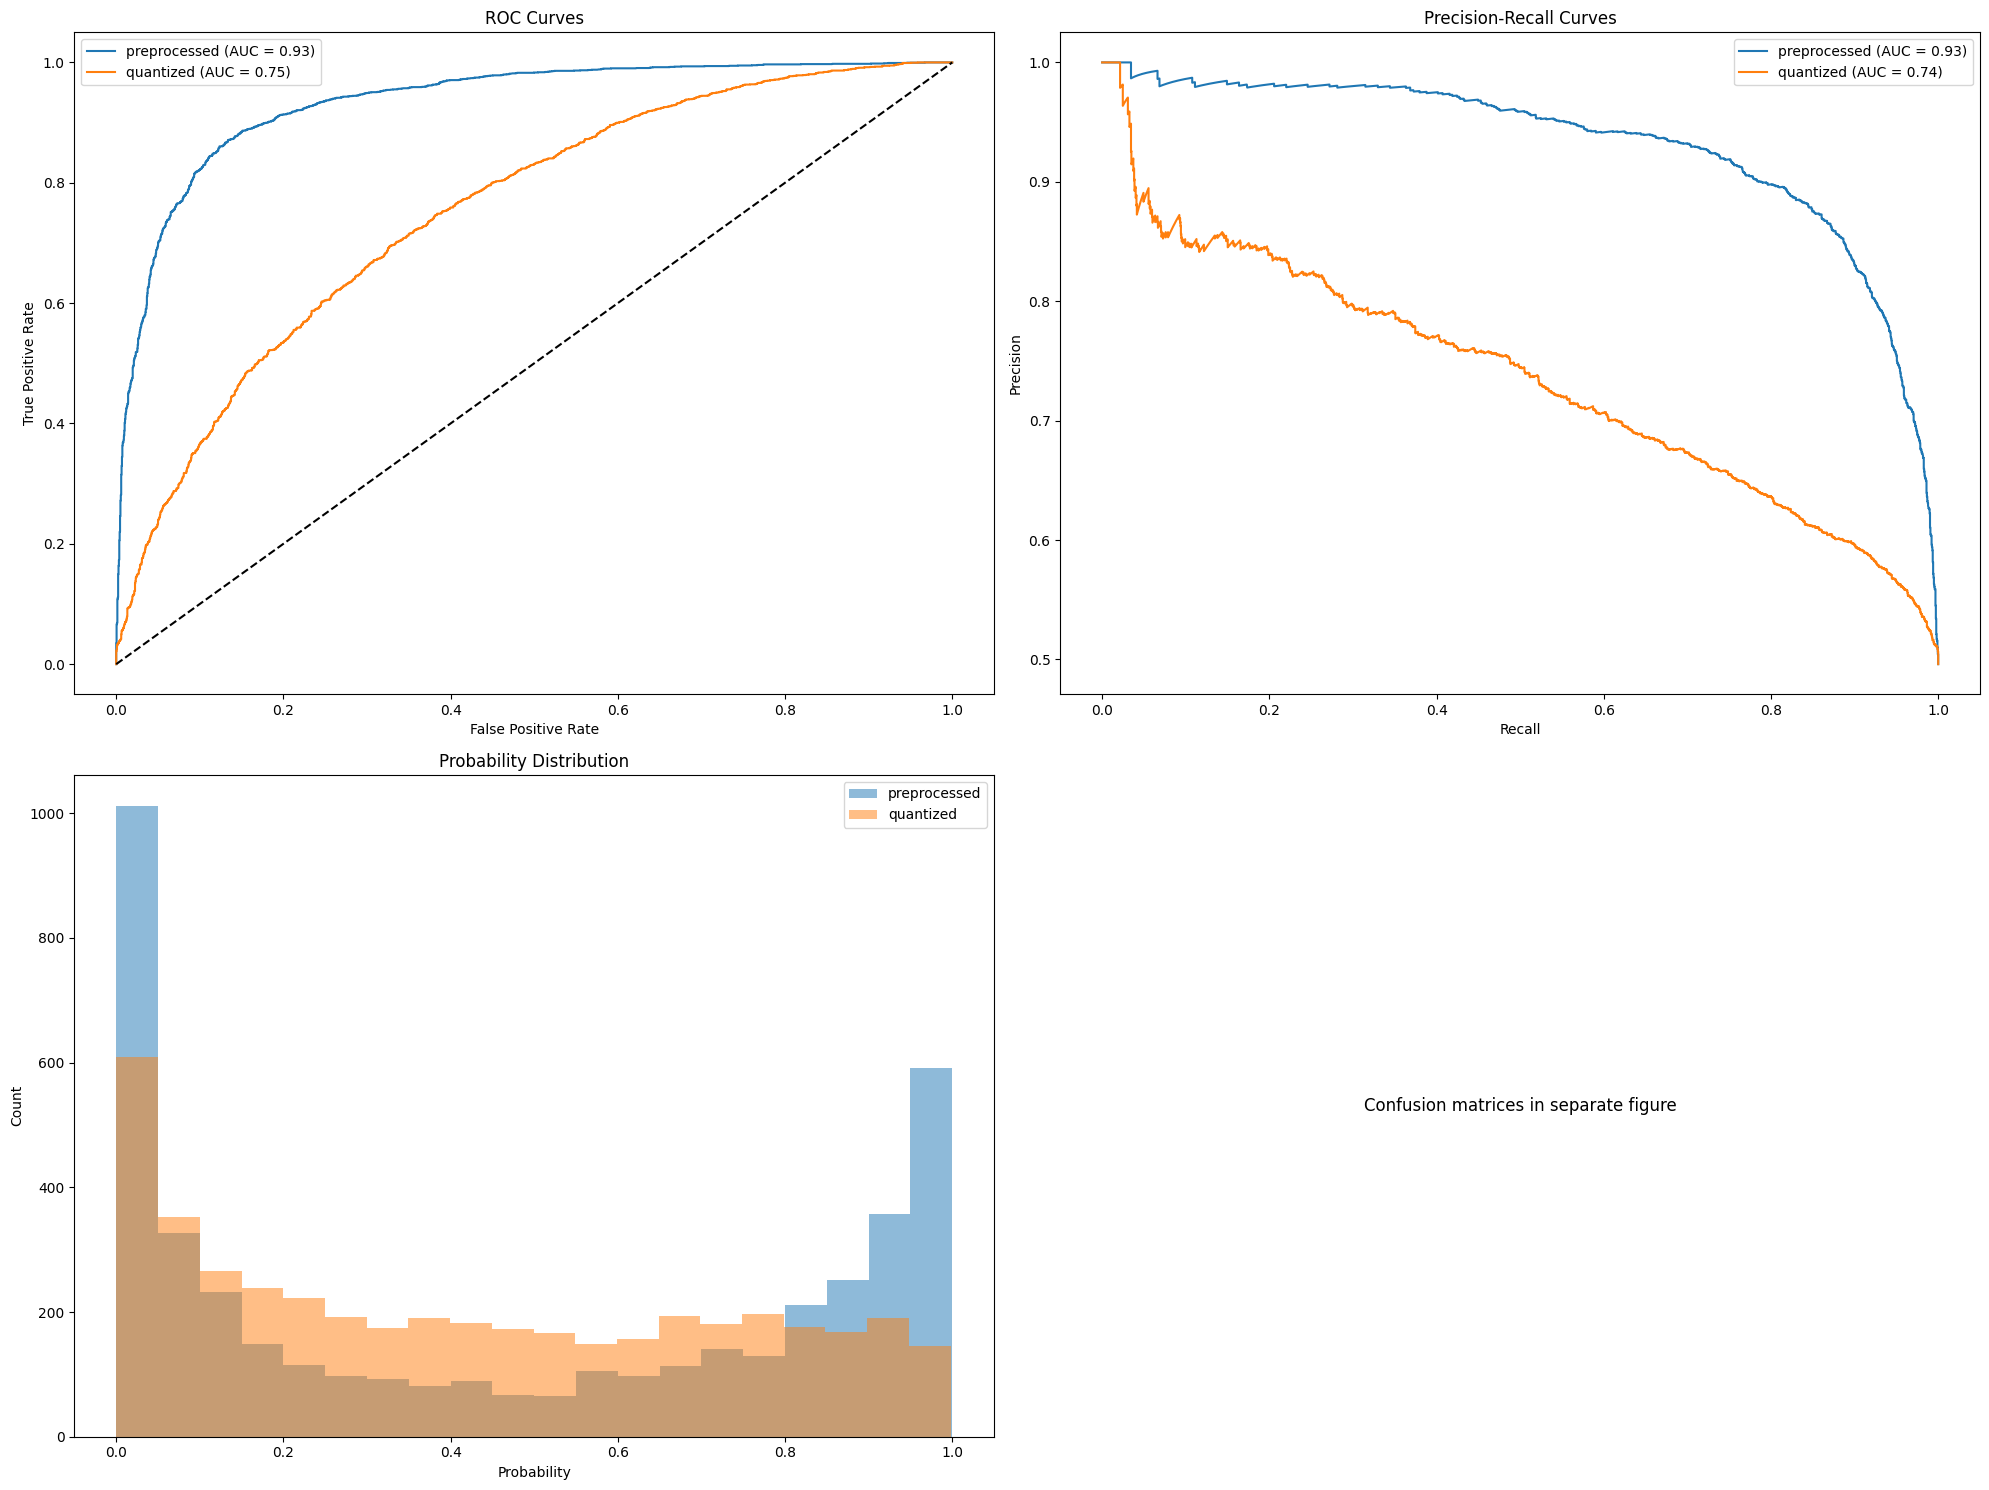

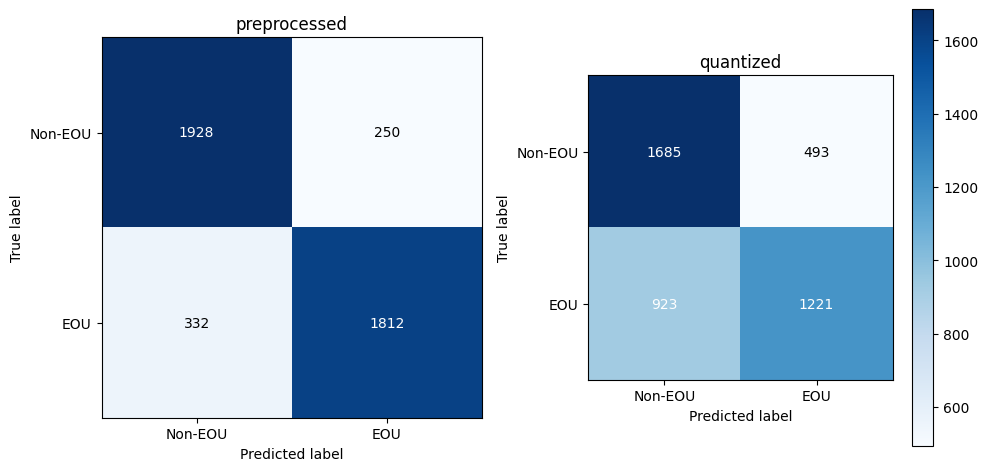


Detailed Performance Metrics:

PREPROCESSED MODEL:
----------------------------------------
Accuracy: 0.8653

Confusion Matrix:
                 Predicted
                 Non-EOU  EOU
Actual Non-EOU     1928     250
      EOU           332    1812

Classification Report:
              precision    recall  f1-score   support

     Non-EOU       0.85      0.89      0.87      2178
         EOU       0.88      0.85      0.86      2144

    accuracy                           0.87      4322
   macro avg       0.87      0.87      0.87      4322
weighted avg       0.87      0.87      0.87      4322


QUANTIZED MODEL:
----------------------------------------
Accuracy: 0.6724

Confusion Matrix:
                 Predicted
                 Non-EOU  EOU
Actual Non-EOU     1685     493
      EOU           923    1221

Classification Report:
              precision    recall  f1-score   support

     Non-EOU       0.65      0.77      0.70      2178
         EOU       0.71      0.57      0.63      2

In [5]:
import onnxruntime
import numpy as np
import json
import matplotlib.pyplot as plt
import random
from sklearn.metrics import roc_curve, auc, precision_recall_curve, confusion_matrix, classification_report
from transformers import AutoTokenizer
from huggingface_hub import hf_hub_download
from datasets import Dataset

# Load tokenizer from the intended repo
print("Loading tokenizer...")
tokenizer = AutoTokenizer.from_pretrained("latishab/turnsense")

# Download ONNX models
print("Downloading ONNX models...")
models = {
    "preprocessed": hf_hub_download(
        repo_id="latishab/turnsense",
        filename="model_preprocessed.onnx"
    ),
    "quantized": hf_hub_download(
        repo_id="latishab/turnsense",
        filename="model_quantized.onnx"
    )
}

# Initialize ONNX Runtime sessions for each model
print("Initializing ONNX Runtime sessions...")
sessions = {
    name: onnxruntime.InferenceSession(path)
    for name, path in models.items()
}
print("Successfully loaded ONNX models")

def format_conversation(example):
    """
    Formats a conversation from your dataset format.
    """
    # Check if the example has a context field with 3 turns
    if 'context' in example and len(example['context']) == 3:
        formatted_text = (
            f"<|user|> {example['context'][0]['content'].strip()} <|im_end|> "
            f"<|assistant|> {example['context'][1]['content'].strip()} <|im_end|> "
            f"<|user|> {example['context'][2]['content'].strip()} <|im_end|>"
        )
        return formatted_text
    else:
        raise ValueError("Example doesn't have the expected context format")

def load_local_dataset():
    """
    Load and split the dataset as in your training code
    """
    # Load the dataset
    with open("labeled_dataset.json", "r", encoding="utf-8") as f:
        data = json.load(f)

    # Split by label
    label_0 = [entry for entry in data if entry.get("label") == 0]
    label_1 = [entry for entry in data if entry.get("label") == 1]

    # Use the same random seed as in your training code for consistency
    random.seed(42)
    random.shuffle(label_0)
    random.shuffle(label_1)

    # Stratified Split (80/20) for Each Label
    split_0 = int(len(label_0) * 0.8)
    split_1 = int(len(label_1) * 0.8)

    test_label_0 = label_0[split_0:]
    test_label_1 = label_1[split_1:]

    # Combine the test splits
    test_data = test_label_0 + test_label_1
    random.shuffle(test_data)

    return Dataset.from_list(test_data)

def evaluate_on_test_set(sessions, tokenizer, max_examples=None):
    results = {}
    for model_name in sessions:
        results[model_name] = {'probs': [], 'preds': [], 'correct': 0}

    labels = []

    # Load the test dataset
    print("Loading local test dataset...")
    test_dataset = load_local_dataset()
    print(f"Loaded test dataset with {len(test_dataset)} examples")

    # Limit examples if specified
    if max_examples and max_examples < len(test_dataset):
        test_dataset = test_dataset.select(range(max_examples))
        print(f"Using first {max_examples} examples for evaluation")

    # Count class distribution
    class_counts = {"EOU (1)": 0, "Non-EOU (0)": 0}

    total = len(test_dataset)
    for i, example in enumerate(test_dataset):
        if i % 20 == 0:
            print(f"Processing example {i+1}/{total}...")

        # Get label
        label = example['label']

        # Update class distribution
        if label == 1:
            class_counts["EOU (1)"] += 1
        else:
            class_counts["Non-EOU (0)"] += 1

        try:
            # Format the conversation
            input_text = format_conversation(example)

            # Tokenize input text
            inputs = tokenizer(
                input_text,
                return_tensors="np",
                truncation=True,
                padding=True,
                max_length=128
            )

            # Prepare inputs for ONNX models
            ort_inputs = {
                'input_ids': inputs['input_ids'].astype(np.int64),
                'attention_mask': inputs['attention_mask'].astype(np.int64)
            }

            # Get predictions from each ONNX model
            for model_name, session in sessions.items():
                try:
                    output = session.run(None, ort_inputs)[0]

                    # Print output shape for the first example
                    if i == 0:
                        print(f"{model_name} output shape: {output.shape}")

                    # Handle different output formats
                    if len(output.shape) > 1 and output.shape[1] == 2:
                        # If output has shape [batch_size, 2] (logits or probabilities)
                        prob = float(output[0, 1])  # Take probability for class 1 (EOU)
                    else:
                        # If output has shape [batch_size] (single probability)
                        prob = float(output[0])

                    pred = 1 if prob > 0.5 else 0
                    results[model_name]['probs'].append(prob)
                    results[model_name]['preds'].append(pred)
                    if pred == label:
                        results[model_name]['correct'] += 1
                except Exception as e:
                    print(f"Error with {model_name} model on example {i}: {e}")
                    # Use a default value to keep arrays aligned
                    results[model_name]['probs'].append(0.5)
                    results[model_name]['preds'].append(0)

            labels.append(label)

        except Exception as e:
            print(f"Error processing example {i}: {e}")
            # Skip this example
            continue

    # Print class distribution
    print("\nClass Distribution in Test Set:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} ({count/len(labels)*100:.1f}%)")

    return results, labels

def plot_results(results, labels):
    # Create a figure with 2 rows and 2 columns
    fig = plt.figure(figsize=(20, 15))

    # Create the subplots with proper spacing
    ax1 = fig.add_subplot(2, 2, 1)  # ROC curve
    ax2 = fig.add_subplot(2, 2, 2)  # Precision-Recall curve
    ax3 = fig.add_subplot(2, 2, 3)  # Probability distribution
    ax4 = fig.add_subplot(2, 2, 4)  # Confusion matrices

    # Plot ROC curves for each model
    for model_name in results:
        fpr, tpr, _ = roc_curve(labels, results[model_name]['probs'])
        roc_auc = auc(fpr, tpr)
        ax1.plot(fpr, tpr, label=f'{model_name} (AUC = {roc_auc:.2f})')
    ax1.plot([0, 1], [0, 1], 'k--')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.set_title('ROC Curves')
    ax1.legend()

    # Plot Precision-Recall curves
    for model_name in results:
        precision, recall, _ = precision_recall_curve(labels, results[model_name]['probs'])
        pr_auc = auc(recall, precision)
        ax2.plot(recall, precision, label=f'{model_name} (AUC = {pr_auc:.2f})')
    ax2.set_xlabel('Recall')
    ax2.set_ylabel('Precision')
    ax2.set_title('Precision-Recall Curves')
    ax2.legend()

    # Plot probability distributions
    for model_name in results:
        ax3.hist(results[model_name]['probs'], bins=20, alpha=0.5, label=model_name)
    ax3.set_xlabel('Probability')
    ax3.set_ylabel('Count')
    ax3.set_title('Probability Distribution')
    ax3.legend()

    # Create a separate figure for confusion matrices
    cm_fig, cm_axes = plt.subplots(1, len(results), figsize=(5*len(results), 5))

    # If there's only one model, cm_axes won't be an array
    if len(results) == 1:
        cm_axes = [cm_axes]

    # Plot confusion matrices for each model
    for i, model_name in enumerate(results):
        # Calculate confusion matrix
        cm = confusion_matrix(labels, results[model_name]['preds'])

        # Plot as heatmap
        im = cm_axes[i].imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        cm_axes[i].set_title(f'{model_name}')

        # Add labels
        cm_axes[i].set_xticks([0, 1])
        cm_axes[i].set_yticks([0, 1])
        cm_axes[i].set_xticklabels(['Non-EOU', 'EOU'])
        cm_axes[i].set_yticklabels(['Non-EOU', 'EOU'])
        cm_axes[i].set_ylabel('True label')
        cm_axes[i].set_xlabel('Predicted label')

        # Add text annotations
        thresh = cm.max() / 2
        for i_cm in range(cm.shape[0]):
            for j_cm in range(cm.shape[1]):
                cm_axes[i].text(j_cm, i_cm, format(cm[i_cm, j_cm], 'd'),
                        ha="center", va="center",
                        color="white" if cm[i_cm, j_cm] > thresh else "black")

    # Add a colorbar to the last confusion matrix
    plt.colorbar(im, ax=cm_axes[-1])

    # Remove the confusion matrix plot from the main figure
    ax4.axis('off')
    ax4.text(0.5, 0.5, "Confusion matrices in separate figure",
             ha='center', va='center', fontsize=12)

    # Adjust layout and save figures
    fig.tight_layout()
    fig.savefig('model_comparison_metrics.png', dpi=300)
    cm_fig.tight_layout()
    cm_fig.savefig('confusion_matrices.png', dpi=300)
    plt.show()

    # Print detailed metrics for each model
    print("\nDetailed Performance Metrics:")
    print("=" * 60)

    for model_name in results:
        preds = results[model_name]['preds']
        accuracy = results[model_name]['correct'] / len(labels)

        print(f"\n{model_name.upper()} MODEL:")
        print("-" * 40)
        print(f"Accuracy: {accuracy:.4f}")

        # Confusion matrix
        cm = confusion_matrix(labels, preds)
        print("\nConfusion Matrix:")
        print("                 Predicted")
        print("                 Non-EOU  EOU")
        print(f"Actual Non-EOU   {cm[0,0]:6d}  {cm[0,1]:6d}")
        print(f"      EOU        {cm[1,0]:6d}  {cm[1,1]:6d}")

        # Classification report
        print("\nClassification Report:")
        print(classification_report(labels, preds, target_names=["Non-EOU", "EOU"]))

    # Print average probability difference between models
    if 'preprocessed' in results and 'quantized' in results:
        prob_diffs = np.abs(
            np.array(results['preprocessed']['probs']) -
            np.array(results['quantized']['probs'])
        )
        print(f"\nAverage probability difference between preprocessed and quantized: {prob_diffs.mean():.4f}")

# Evaluate on the test set (use all examples or limit with max_examples parameter)
print("Starting evaluation on test set...")
results, labels = evaluate_on_test_set(sessions, tokenizer, max_examples=None)

if results and labels:
    plot_results(results, labels)
else:
    print("Evaluation failed. Check the error messages above.")

# **Future Work: Making EOU Detection More Robust**

While testing our EOU model, I've identified several edge cases. Although phrases like "thank you goodbye" clearly indicate end-of-utterance, real conversations contain ambiguity. For example, "I'm interested in restaurants in the east" could be complete or the beginning of a more specific request.

Since this model will likely process speech recognition output, we should train it on more realistic data that includes informal language ("thx bye"), regional speech patterns ("lemme know bout places in cambridge"), and false endings ("thanks for that and actually one more thing"). Speech-to-text imperfections must also be accounted for in our training approach.

A significant improvement would come from integrating Voice Activity Detection (VAD) and other modalities. Text alone misses crucial contextual cues - like sarcastic versus sincere delivery of "sure, thanks," or subtle pauses indicating a speaker isn't finished. A multimodal approach incorporating text, audio features (tone, pitch, pauses), and potentially visual cues would substantially enhance EOU detection accuracy.

I believe we should bias the model toward non-EOU predictions to minimize false positives. Sentences ending with periods are particularly ambiguous - they could represent complete thoughts (likely EOU), abbreviations (likely non-EOU), or partial statements that could be interpreted either way.